In [20]:
# Install required packages
%pip install pandas numpy matplotlib seaborn scikit-learn scipy statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Air Quality Data Analysis - EDA & Preprocessing

This notebook is structured in two main parts:

## Part 1: Exploratory Data Analysis (EDA)
1. Time series visualization
2. Seasonal decomposition
3. Correlation heatmap
4. Pairplot analysis
5. Boxplot distributions

## Part 2: Data Preprocessing
1. Handle -200 missing values (mark as NaN, record missing rates)
2. Implement filling strategies:
   - Meteorological variables: linear time interpolation
   - Sensors/pollutants: forward/backward fill or hourly mean imputation
3. Detect and classify extreme values (IQR/Z-score)
4. Merge Date+Time, extract temporal features
5. Implement chronological split (2004 train, 2005 test)
6. Apply StandardScaler (fit on train only)

## Setup: Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## Load & Initial Inspection

In [22]:
# Load data with European format (semicolon separator, comma decimal)
df_raw = pd.read_csv('../air+quality/AirQualityUCI.csv', sep=';', decimal=',')

# Remove empty columns
df_raw = df_raw.dropna(axis=1, how='all')

# Merge Date and Time into DateTime
df_raw['DateTime'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'], 
                                     format='%d/%m/%Y %H.%M.%S', errors='coerce')
df_raw = df_raw[df_raw['DateTime'].notna()].copy()
df_raw.set_index('DateTime', inplace=True)
df_raw.drop(['Date', 'Time'], axis=1, inplace=True)
df_raw.sort_index(inplace=True)

print(f"Dataset shape: {df_raw.shape}")
print(f"Date range: {df_raw.index.min()} to {df_raw.index.max()}")
print(f"Duration: {(df_raw.index.max() - df_raw.index.min()).days} days")
print(f"\nColumns: {df_raw.columns.tolist()}")
df_raw.head()

Dataset shape: (9357, 13)
Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Duration: 389 days

Columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
DateTime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [23]:
# Define variable groups for consistent use throughout the notebook
pollutant_list = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensor_list = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
meteo_vars = ['T', 'RH', 'AH']
continuous_features = pollutant_list + sensor_list + meteo_vars

print("=== Variable Groups Defined ===")
print(f"Pollutants (5): {pollutant_list}")
print(f"Sensors (5): {sensor_list}")
print(f"Meteorological (3): {meteo_vars}")
print(f"Total continuous features: {len(continuous_features)}")

=== Variable Groups Defined ===
Pollutants (5): ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
Sensors (5): ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
Meteorological (3): ['T', 'RH', 'AH']
Total continuous features: 13


# PART 1: EXPLORATORY DATA ANALYSIS (EDA)

---

## 1.1 Time Series Visualization

### 1.1.1 Original Hourly Time Series

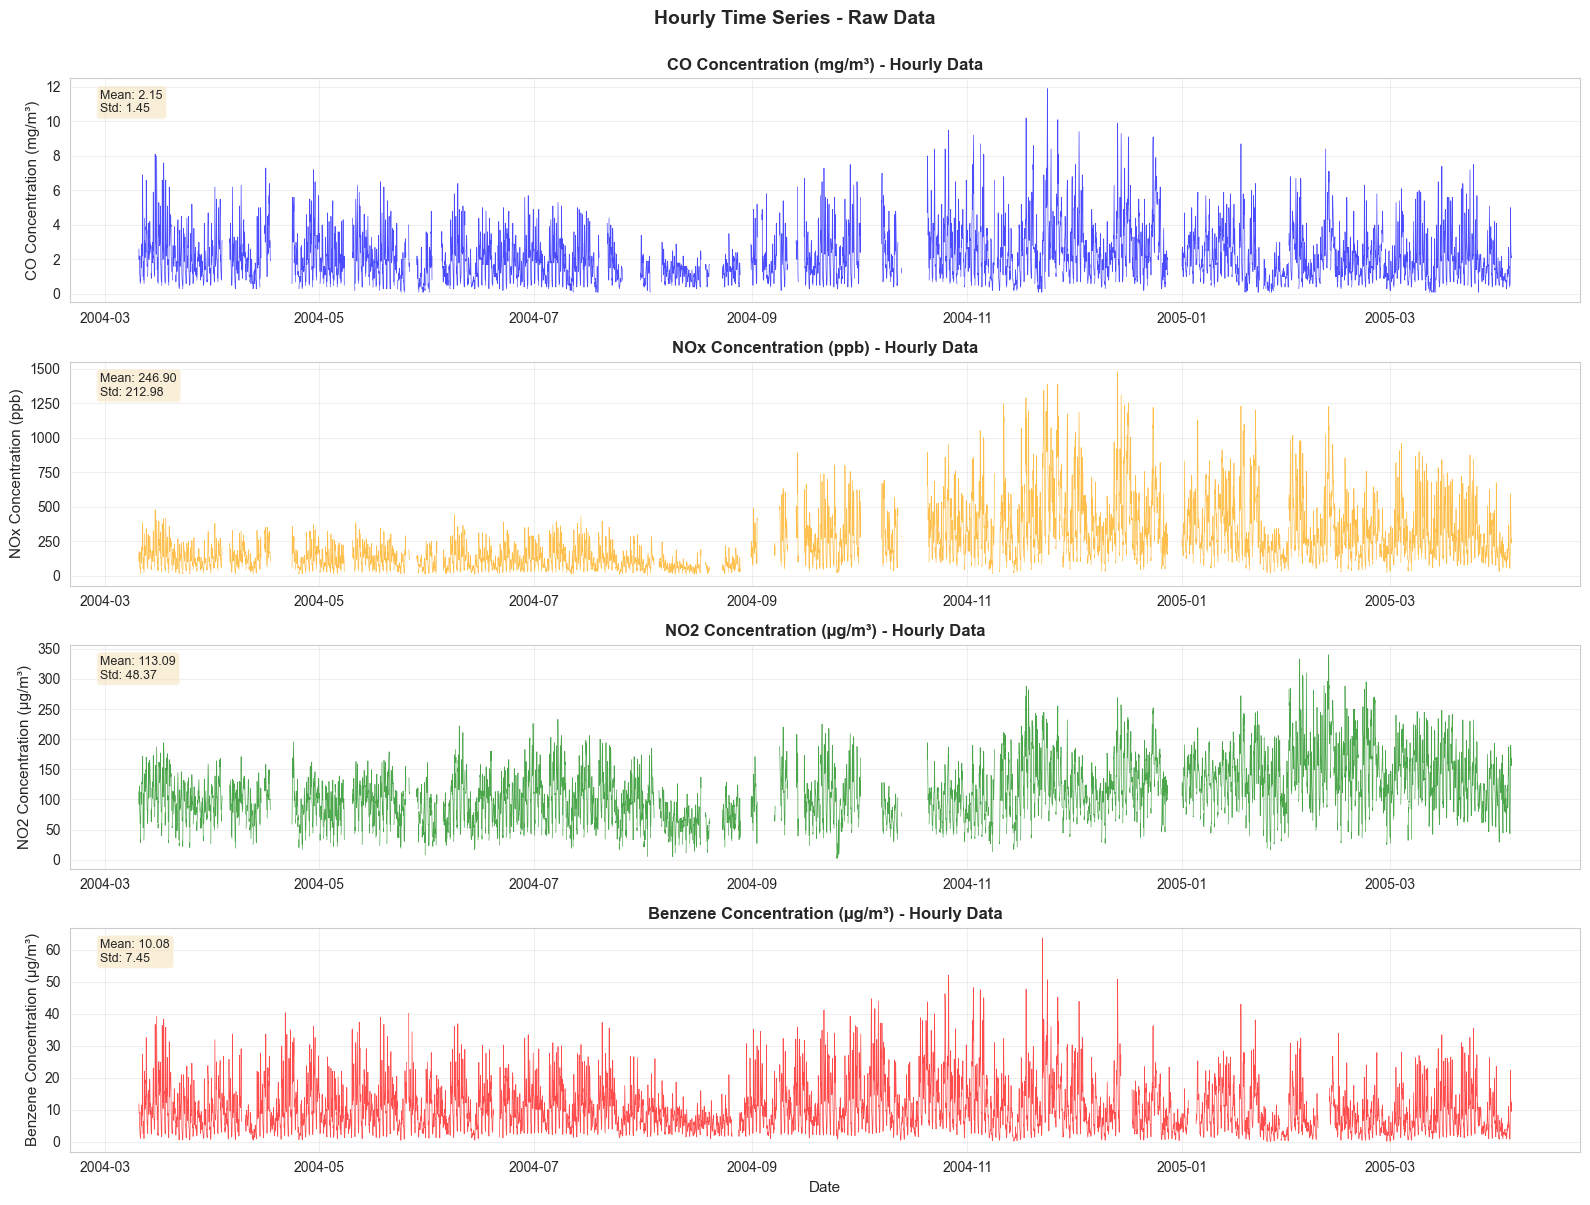

In [24]:
# Original hourly time series for key pollutants
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

pollutants = [
    ('CO(GT)', 'CO Concentration (mg/m³)', 'blue'),
    ('NOx(GT)', 'NOx Concentration (ppb)', 'orange'),
    ('NO2(GT)', 'NO2 Concentration (µg/m³)', 'green'),
    ('C6H6(GT)', 'Benzene Concentration (µg/m³)', 'red')
]

for idx, (col, title, color) in enumerate(pollutants):
    # Replace -200 with NaN for visualization
    data = df_raw[col].replace(-200, np.nan)
    
    axes[idx].plot(data.index, data.values, linewidth=0.5, color=color, alpha=0.7)
    axes[idx].set_ylabel(title, fontsize=11)
    axes[idx].set_title(f'{title} - Hourly Data', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    valid_data = data.dropna()
    axes[idx].text(0.02, 0.95, f'Mean: {valid_data.mean():.2f}\nStd: {valid_data.std():.2f}', 
                   transform=axes[idx].transAxes, fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   verticalalignment='top')

axes[-1].set_xlabel('Date', fontsize=11)
plt.suptitle('Hourly Time Series - Raw Data', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 1.1.2 Daily Aggregated Time Series

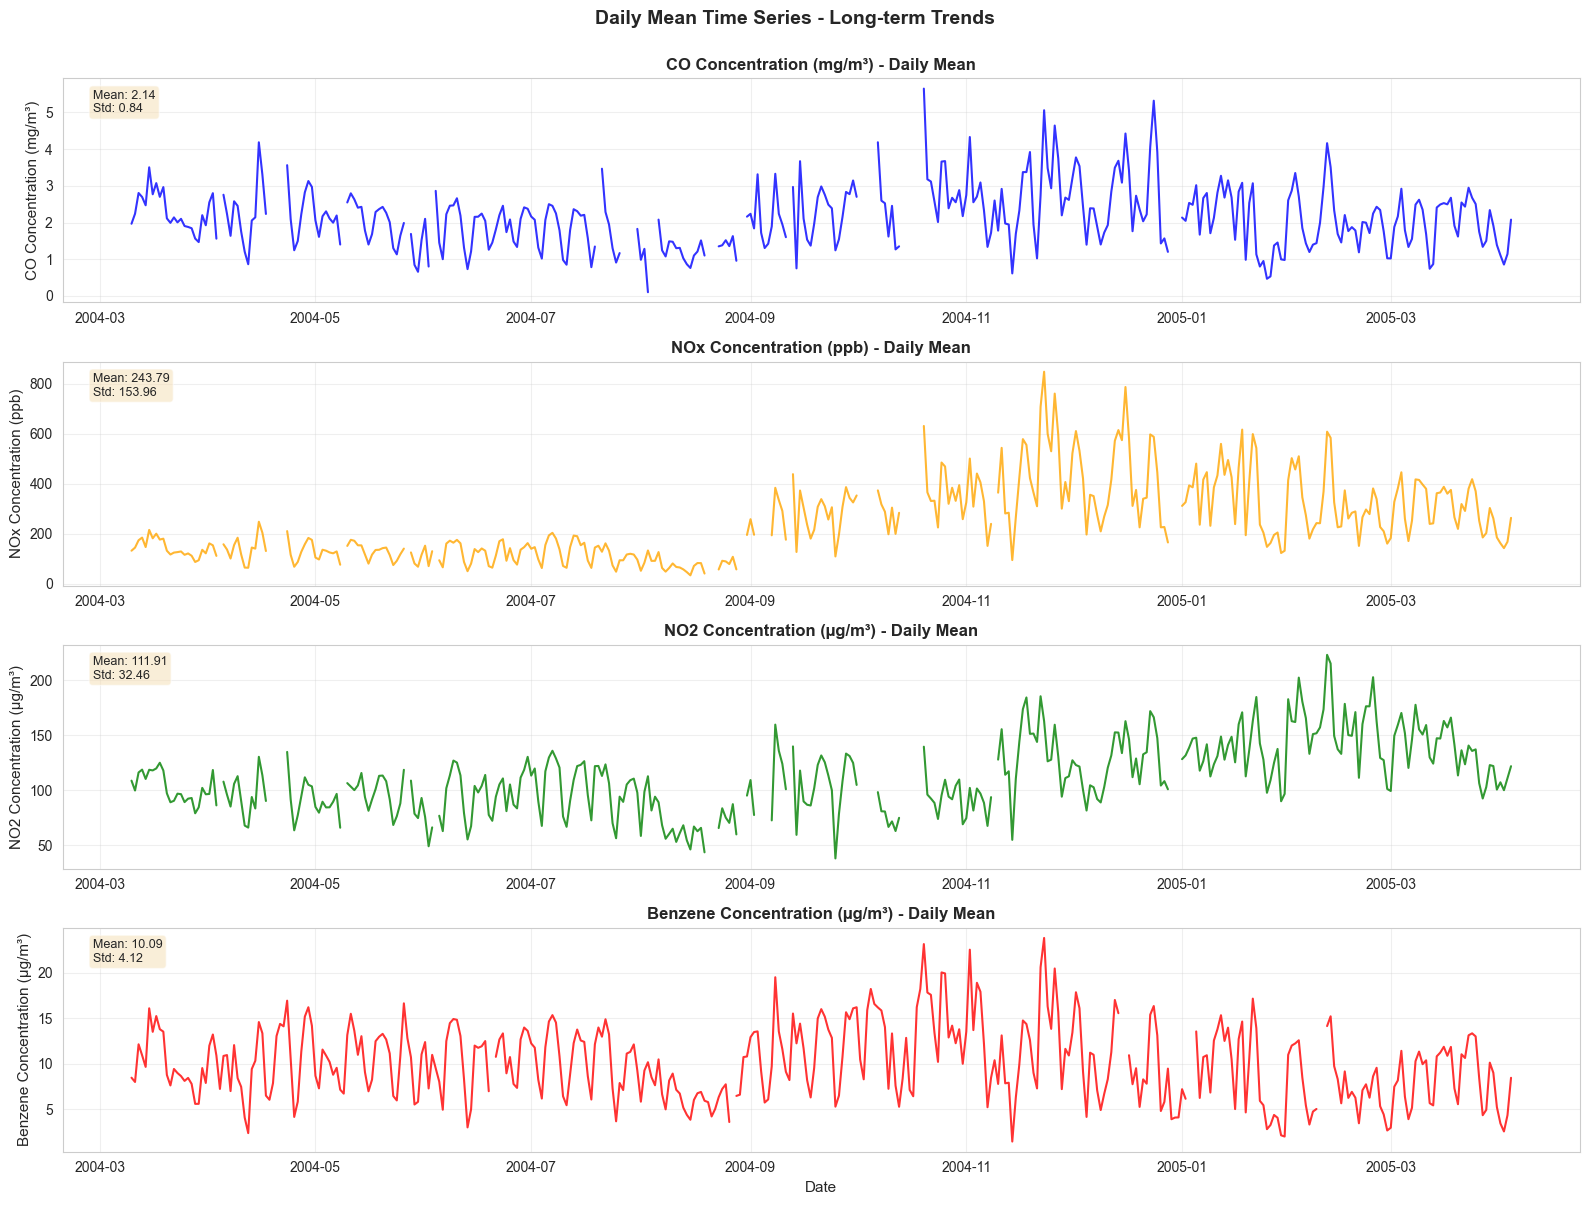

In [25]:
# Daily mean time series to see long-term trends
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, (col, title, color) in enumerate(pollutants):
    # Replace -200 with NaN and resample to daily mean
    data = df_raw[col].replace(-200, np.nan)
    daily_data = data.resample('D').mean()
    
    axes[idx].plot(daily_data.index, daily_data.values, linewidth=1.5, color=color, alpha=0.8)
    axes[idx].set_ylabel(title, fontsize=11)
    axes[idx].set_title(f'{title} - Daily Mean', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    valid_data = daily_data.dropna()
    axes[idx].text(0.02, 0.95, f'Mean: {valid_data.mean():.2f}\nStd: {valid_data.std():.2f}', 
                   transform=axes[idx].transAxes, fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   verticalalignment='top')

axes[-1].set_xlabel('Date', fontsize=11)
plt.suptitle('Daily Mean Time Series - Long-term Trends', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 1.1.3 Weekly Aggregated Time Series

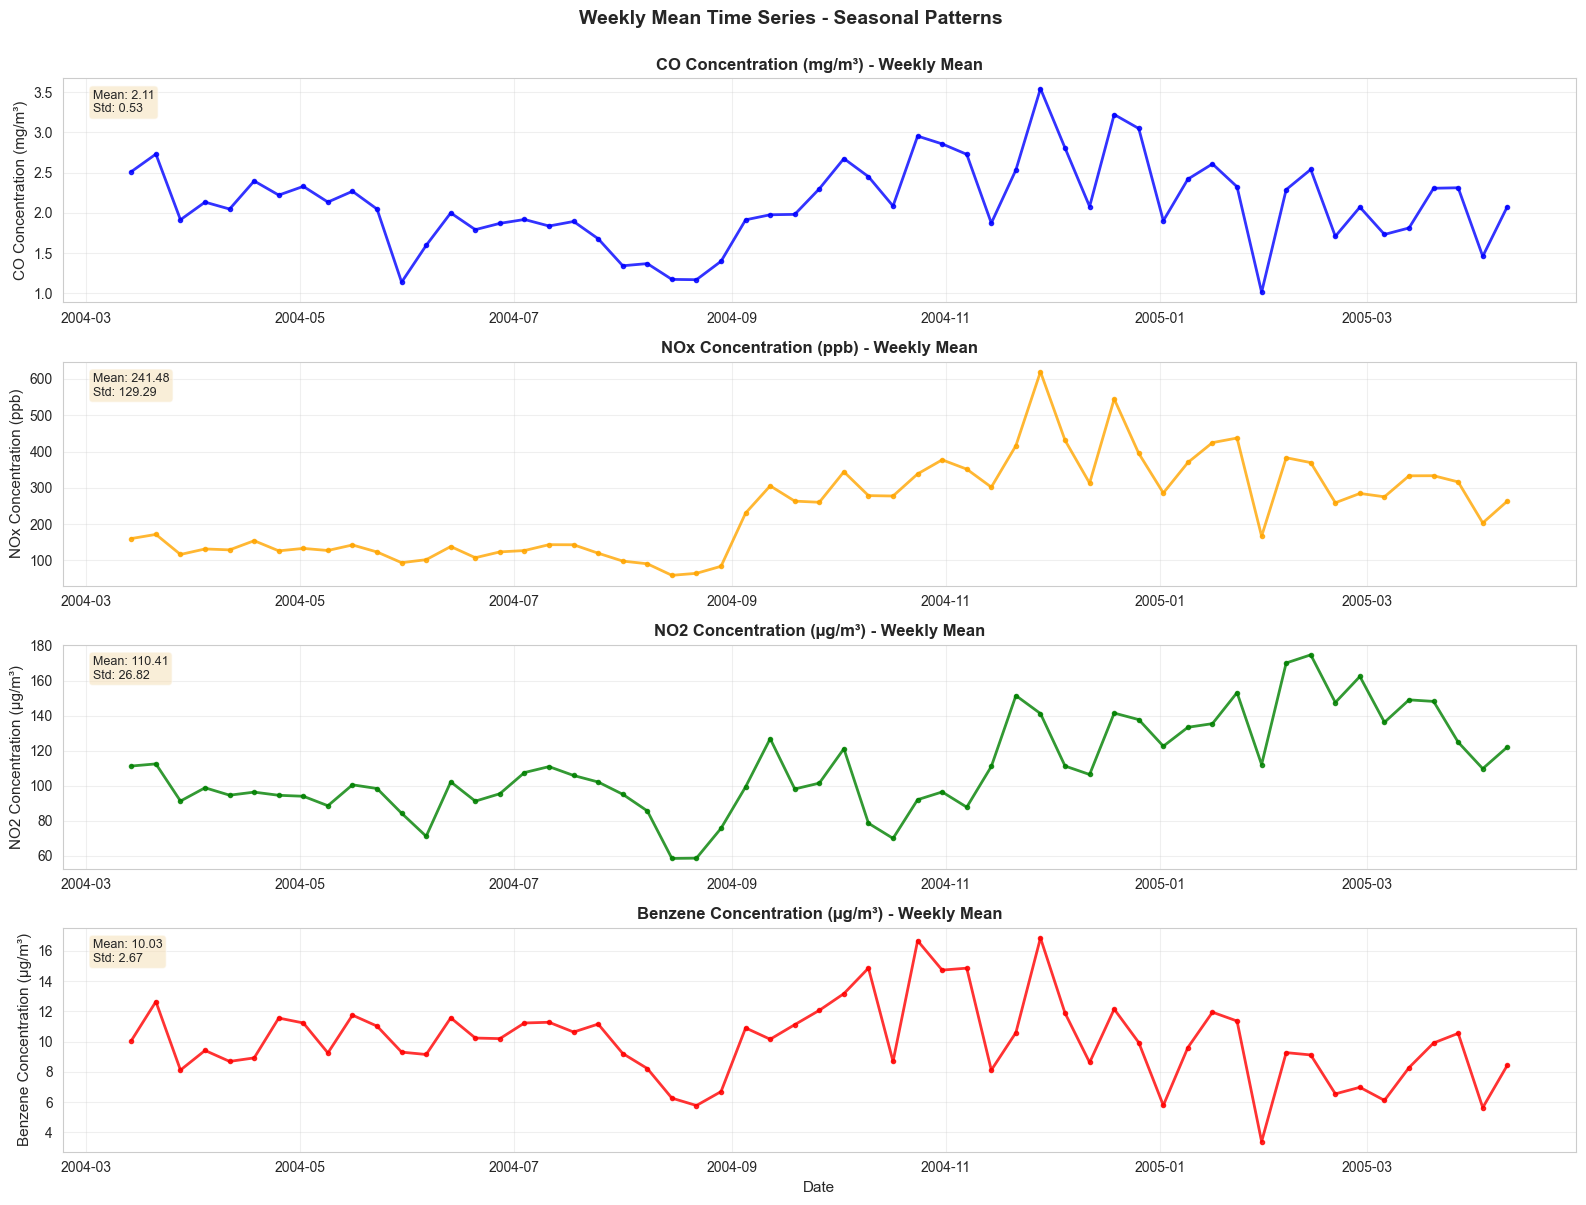

In [26]:
# Weekly mean time series for seasonal patterns
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

for idx, (col, title, color) in enumerate(pollutants):
    # Replace -200 with NaN and resample to weekly mean
    data = df_raw[col].replace(-200, np.nan)
    weekly_data = data.resample('W').mean()
    
    axes[idx].plot(weekly_data.index, weekly_data.values, linewidth=2, color=color, marker='o', markersize=3, alpha=0.8)
    axes[idx].set_ylabel(title, fontsize=11)
    axes[idx].set_title(f'{title} - Weekly Mean', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics and trend
    valid_data = weekly_data.dropna()
    axes[idx].text(0.02, 0.95, f'Mean: {valid_data.mean():.2f}\nStd: {valid_data.std():.2f}', 
                   transform=axes[idx].transAxes, fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   verticalalignment='top')

axes[-1].set_xlabel('Date', fontsize=11)
plt.suptitle('Weekly Mean Time Series - Seasonal Patterns', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 1.2 Seasonal Decomposition

### 1.2.1 Daily Cycle Decomposition (24-hour period)

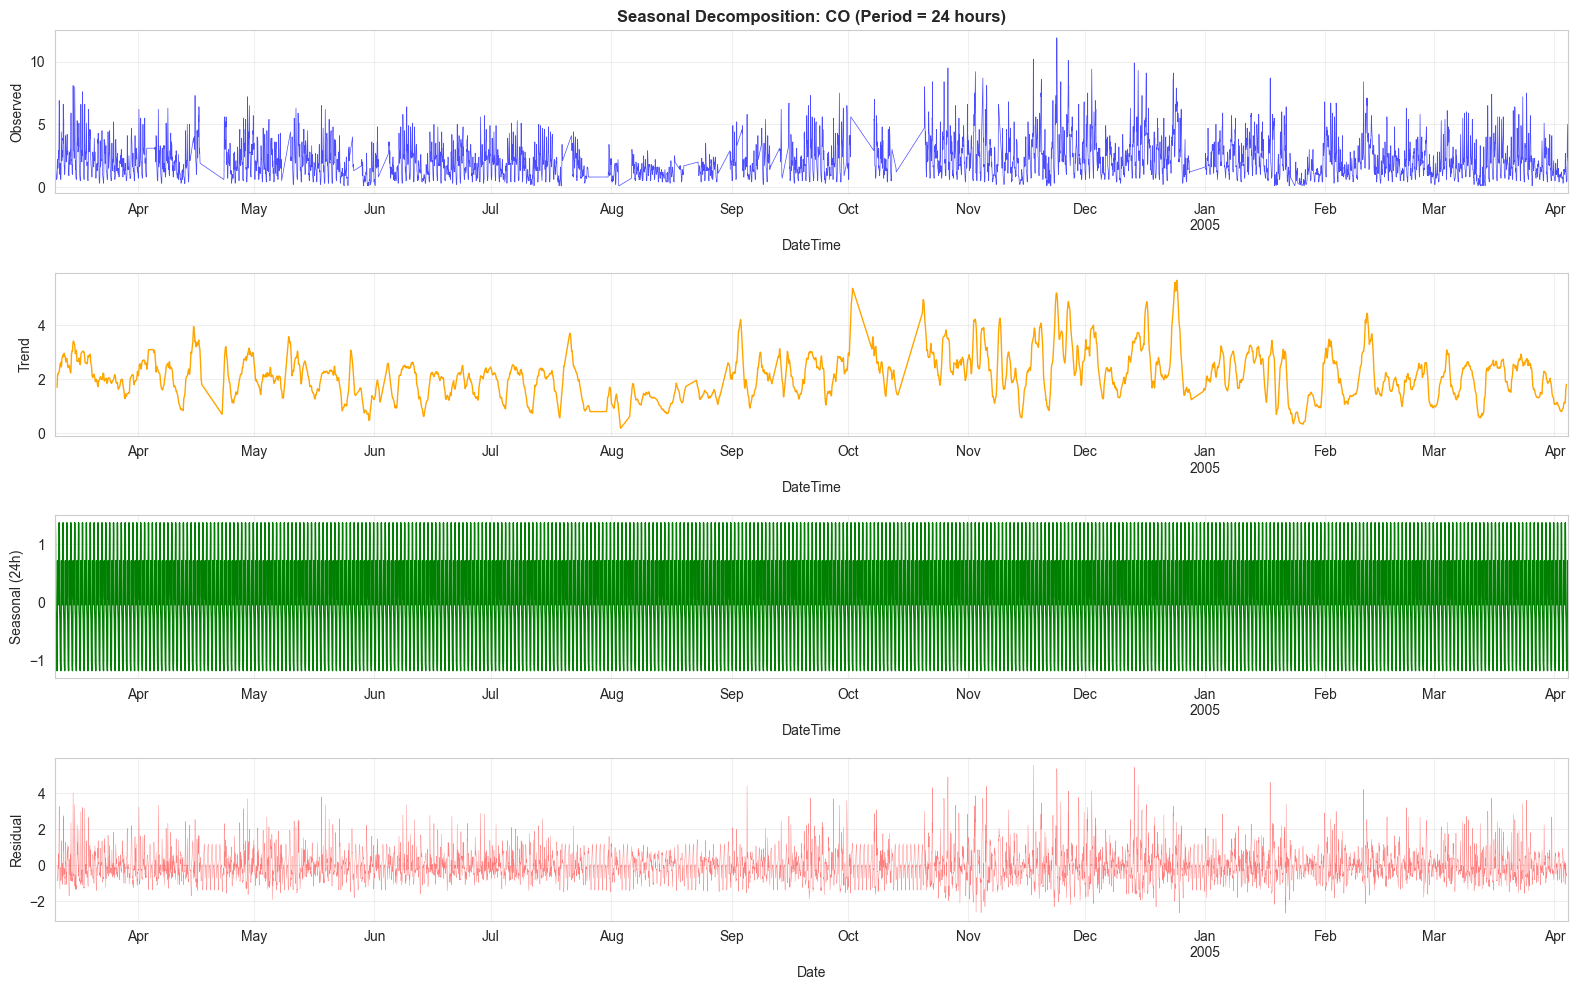

✓ Daily cycle decomposition (24-hour period) completed
  Captures diurnal (day-night) patterns in pollution


In [ ]:
# Seasonal decomposition with daily cycle (period = 24 hours)
# Use only first 2 months of data for clearer visualization
co_hourly = df_raw['CO(GT)'].replace(-200, np.nan).interpolate(method='linear')

# Select first 2 months for detailed view
co_subset = co_hourly['2004-03':'2004-04']
co_subset_clean = co_subset.dropna()

# Decompose with 24-hour period (daily cycle)
decomp_daily = seasonal_decompose(co_subset_clean, model='additive', period=24)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 10))

decomp_daily.observed.plot(ax=axes[0], color='blue', linewidth=1)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title('Seasonal Decomposition: CO (Period = 24 hours) - First 2 Months', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomp_daily.trend.plot(ax=axes[1], color='orange', linewidth=1.5)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

decomp_daily.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
axes[2].set_ylabel('Seasonal (24h)', fontsize=10)
axes[2].grid(True, alpha=0.3)

decomp_daily.resid.plot(ax=axes[3], color='red', linewidth=0.5, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show one complete daily pattern
print("✓ Daily cycle decomposition (24-hour period) completed")
print(f"  Showing first 2 months for clear visualization")
print(f"\n=== Typical 24-hour seasonal pattern ===")
daily_pattern = decomp_daily.seasonal[:24]
print("Hour-by-hour pattern:")
for i, val in enumerate(daily_pattern):
    print(f"  Hour {i:2d}: {val:6.3f}")

### 1.2.2 Weekly Cycle Decomposition (168-hour period)

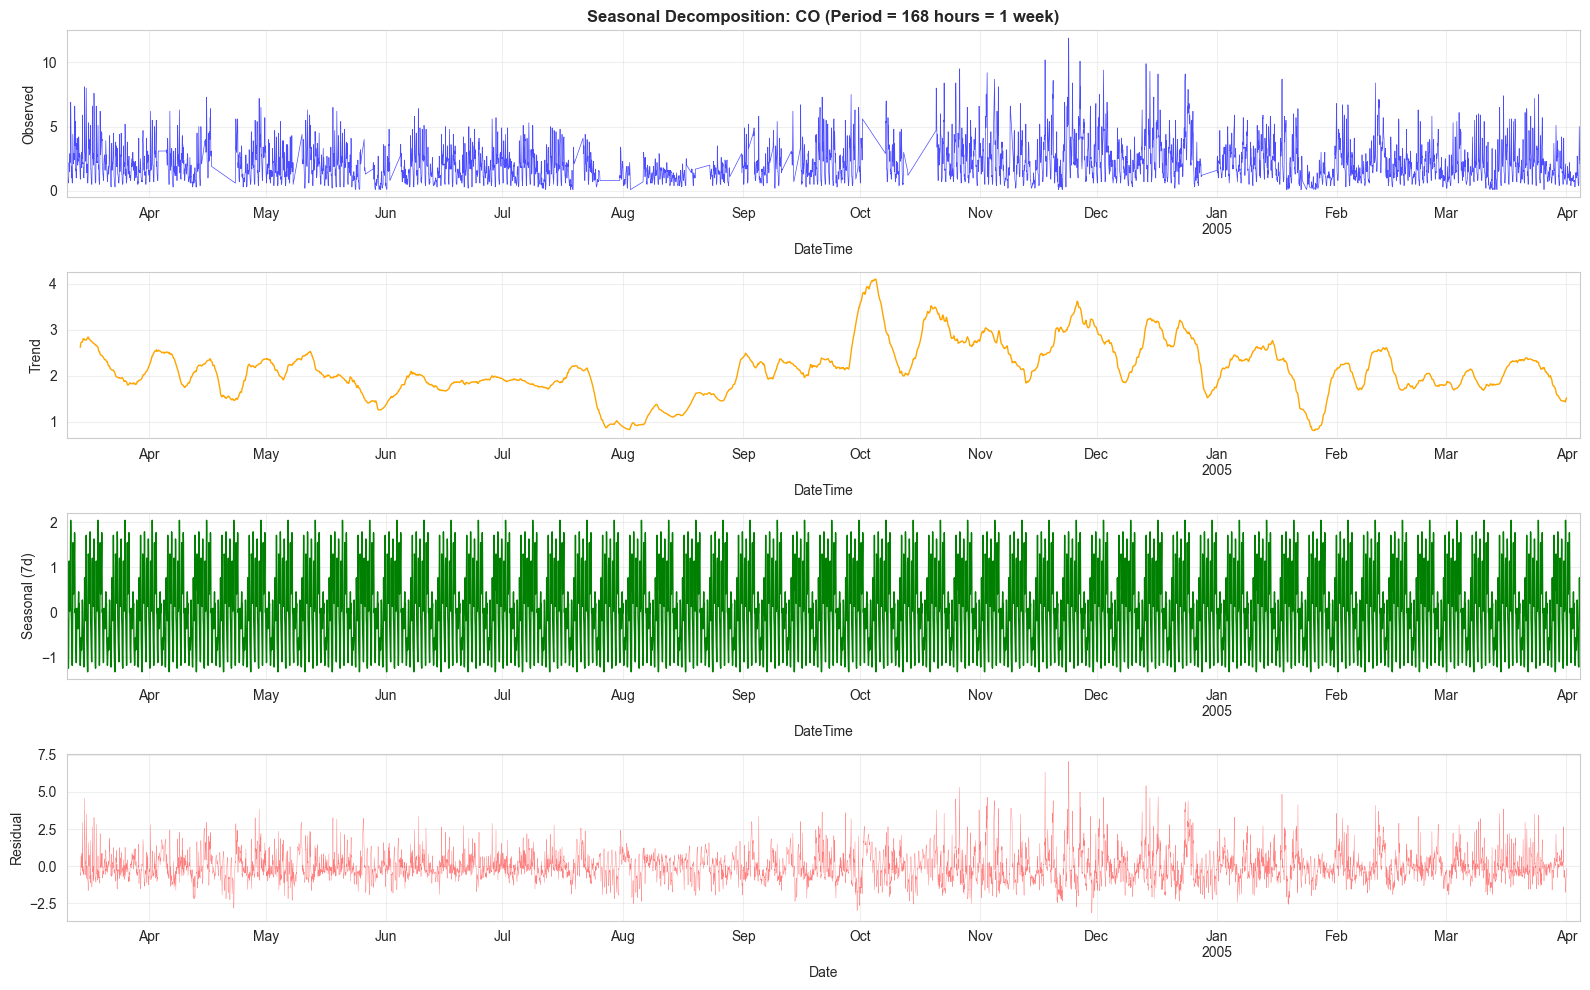

✓ Weekly cycle decomposition (168-hour period) completed
  Captures weekly patterns (weekday vs weekend differences)


In [ ]:
# Seasonal decomposition with weekly cycle (period = 24*7 = 168 hours)
# Use first 3 months for better visualization
co_weekly_subset = co_hourly['2004-03':'2004-05']
co_weekly_clean = co_weekly_subset.dropna()

# Decompose with 168-hour period (weekly cycle)
decomp_weekly = seasonal_decompose(co_weekly_clean, model='additive', period=24*7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 10))

decomp_weekly.observed.plot(ax=axes[0], color='blue', linewidth=1)
axes[0].set_ylabel('Observed', fontsize=10)
axes[0].set_title('Seasonal Decomposition: CO (Period = 168 hours = 1 week) - First 3 Months', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

decomp_weekly.trend.plot(ax=axes[1], color='orange', linewidth=1.5)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

decomp_weekly.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
axes[2].set_ylabel('Seasonal (7d)', fontsize=10)
axes[2].grid(True, alpha=0.3)

decomp_weekly.resid.plot(ax=axes[3], color='red', linewidth=0.5, alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Weekly cycle decomposition (168-hour period) completed")
print(f"  Showing first 3 months for clear visualization")
print(f"  Captures weekly patterns (weekday vs weekend differences)")

# Show one complete weekly pattern (first 168 hours)
print(f"\n=== Typical 7-day seasonal pattern (summary) ===")
weekly_pattern = decomp_weekly.seasonal[:168]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for day_idx in range(7):
    day_data = weekly_pattern[day_idx*24:(day_idx+1)*24]
    print(f"  {days[day_idx]}: Mean={day_data.mean():6.3f}, Range=[{day_data.min():6.3f}, {day_data.max():6.3f}]")

### 1.2.3 Seasonal Pattern Visualization

In [ ]:
# Visualize the extracted seasonal patterns more clearly
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Daily pattern (24 hours)
daily_pattern = decomp_daily.seasonal[:24]
axes[0].plot(range(24), daily_pattern.values, marker='o', linewidth=2, markersize=8, color='green')
axes[0].set_xlabel('Hour of Day', fontsize=11)
axes[0].set_ylabel('Seasonal Component', fontsize=11)
axes[0].set_title('24-Hour Seasonal Pattern (Daily Cycle)', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, 24, 2))
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Mark peak hours
peak_hour = daily_pattern.idxmax().hour
low_hour = daily_pattern.idxmin().hour
axes[0].axvline(x=peak_hour, color='orange', linestyle='--', alpha=0.7, label=f'Peak: {peak_hour}:00')
axes[0].axvline(x=low_hour, color='blue', linestyle='--', alpha=0.7, label=f'Low: {low_hour}:00')
axes[0].legend()

# Weekly pattern (7 days, showing daily averages)
weekly_pattern = decomp_weekly.seasonal[:168]
daily_means = [weekly_pattern[i*24:(i+1)*24].mean() for i in range(7)]
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
colors = ['#1f77b4']*5 + ['#ff7f0e']*2  # Blue for weekdays, orange for weekends

axes[1].bar(days, daily_means, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Day of Week', fontsize=11)
axes[1].set_ylabel('Average Seasonal Component', fontsize=11)
axes[1].set_title('7-Day Seasonal Pattern (Weekly Cycle)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add value labels on bars
for i, (day, val) in enumerate(zip(days, daily_means)):
    axes[1].text(i, val, f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ Seasonal patterns extracted and visualized")
print(f"\nKey findings:")
print(f"  - Daily cycle: Peak at {peak_hour}:00, Low at {low_hour}:00")
print(f"  - Weekly cycle: Weekdays (blue) vs Weekends (orange)")
print(f"  - Weekend effect: {daily_means[5:7]} vs Weekday avg: {np.mean(daily_means[:5]):.3f}")

## 1.3 Correlation Heatmap

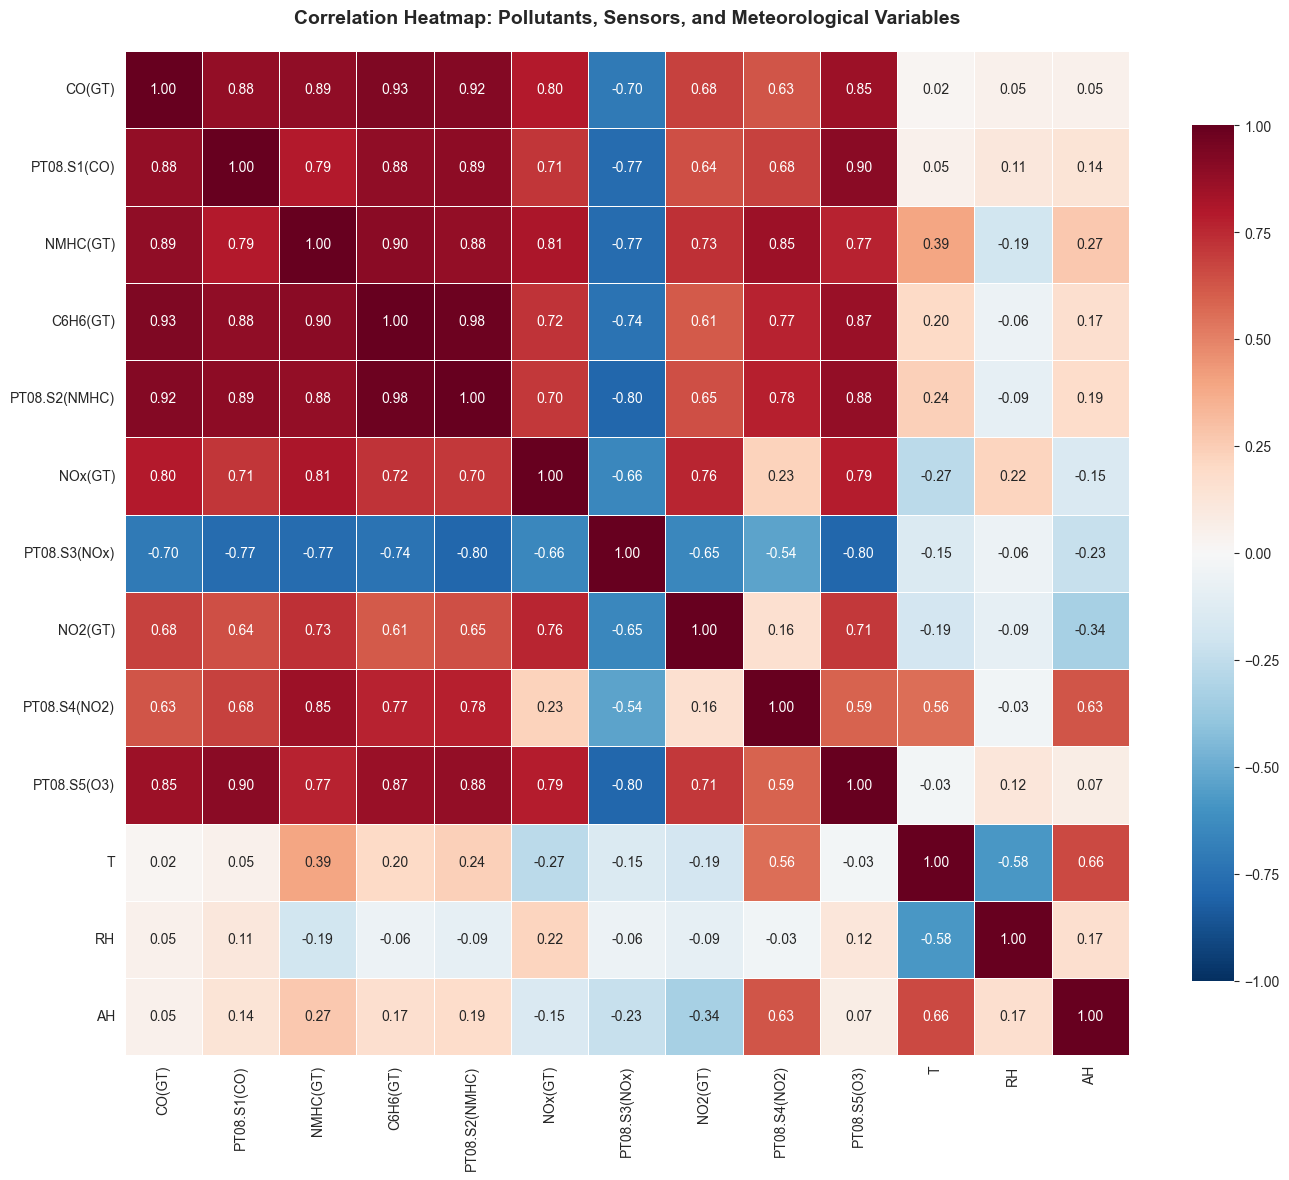

=== Strong Correlations (|r| > 0.7) ===
CO(GT)               <-> PT08.S1(CO)         :  0.879
CO(GT)               <-> NMHC(GT)            :  0.890
CO(GT)               <-> C6H6(GT)            :  0.931
CO(GT)               <-> PT08.S2(NMHC)       :  0.916
CO(GT)               <-> NOx(GT)             :  0.795
CO(GT)               <-> PT08.S3(NOx)        : -0.703
CO(GT)               <-> PT08.S5(O3)         :  0.854
PT08.S1(CO)          <-> NMHC(GT)            :  0.791
PT08.S1(CO)          <-> C6H6(GT)            :  0.884
PT08.S1(CO)          <-> PT08.S2(NMHC)       :  0.893
PT08.S1(CO)          <-> NOx(GT)             :  0.714
PT08.S1(CO)          <-> PT08.S3(NOx)        : -0.772
PT08.S1(CO)          <-> PT08.S5(O3)         :  0.899
NMHC(GT)             <-> C6H6(GT)            :  0.903
NMHC(GT)             <-> PT08.S2(NMHC)       :  0.878
NMHC(GT)             <-> NOx(GT)             :  0.813
NMHC(GT)             <-> PT08.S3(NOx)        : -0.771
NMHC(GT)             <-> NO2(GT)          

In [29]:
# Calculate correlation matrix (replace -200 with NaN)
df_corr = df_raw.replace(-200, np.nan)

# Select key variables for correlation
key_vars = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
            'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']

correlation_matrix = df_corr[key_vars].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Pollutants, Sensors, and Meteorological Variables', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Report strong correlations
print("=== Strong Correlations (|r| > 0.7) ===")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"{correlation_matrix.columns[i]:20s} <-> {correlation_matrix.columns[j]:20s}: {corr_val:6.3f}")

## 1.4 Pairplot Analysis

Creating pairplot with 713 samples...


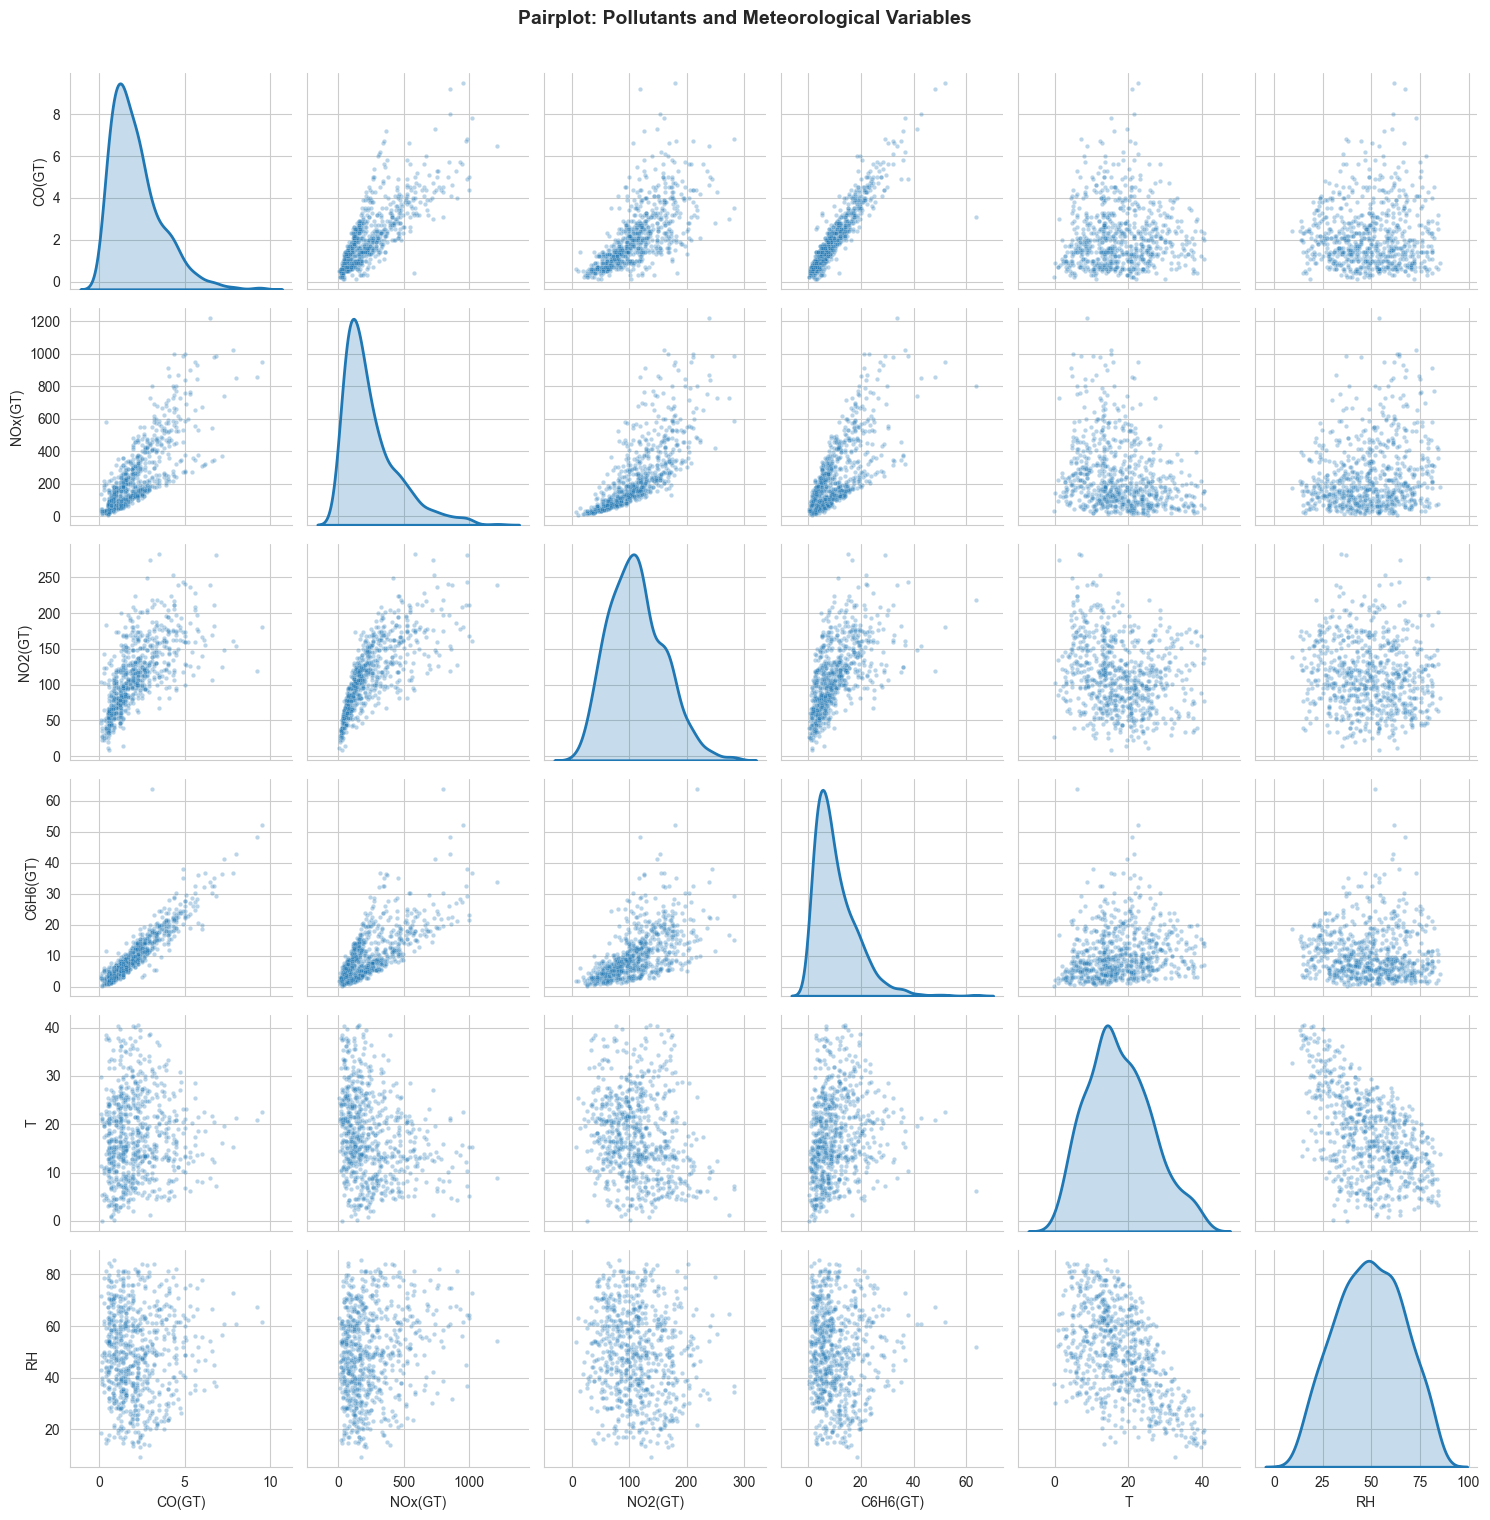

✓ Pairplot completed


In [30]:
# Pairplot for key pollutants and meteorological variables
# Sample data to reduce computation time (every 10th row)
pairplot_vars = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH']
df_sample = df_corr[pairplot_vars].iloc[::10, :].dropna()

print(f"Creating pairplot with {len(df_sample)} samples...")

pairplot = sns.pairplot(df_sample, diag_kind='kde', corner=False,
                        plot_kws={'alpha': 0.3, 's': 10},
                        diag_kws={'linewidth': 2})
pairplot.fig.suptitle('Pairplot: Pollutants and Meteorological Variables', 
                      y=1.01, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Pairplot completed")

## 1.5 Boxplot Distributions

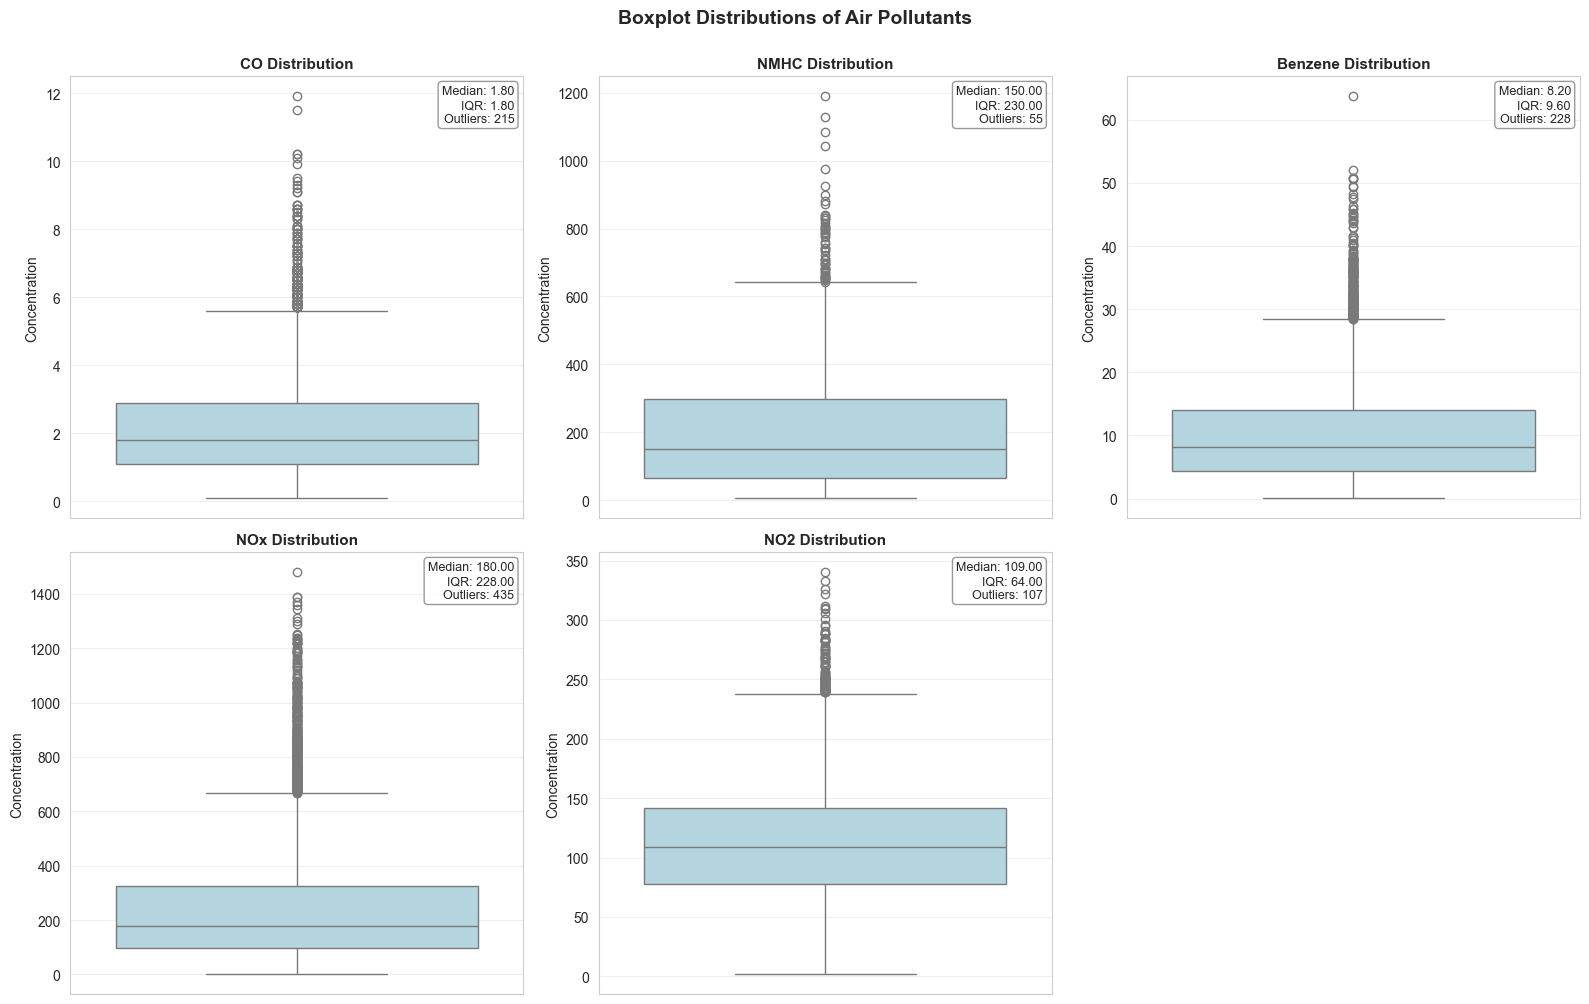

In [31]:
# Boxplots for pollutants
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# pollutant_list already defined earlier
titles = ['CO', 'NMHC', 'Benzene', 'NOx', 'NO2']

for idx, (col, title) in enumerate(zip(pollutant_list, titles)):
    data = df_corr[col].dropna()
    
    # Use seaborn for better boxplot visualization
    sns.boxplot(y=data, ax=axes[idx], color='lightblue')
    axes[idx].set_title(f'{title} Distribution', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Concentration', fontsize=10)
    axes[idx].set_xlabel('')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistics
    q1, median, q3 = data.quantile([0.25, 0.5, 0.75])
    iqr = q3 - q1
    n_outliers = len(data[(data < q1-1.5*iqr) | (data > q3+1.5*iqr)])
    axes[idx].text(0.98, 0.98, 
                   f'Median: {median:.2f}\nIQR: {iqr:.2f}\nOutliers: {n_outliers}',
                   transform=axes[idx].transAxes, fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'),
                   verticalalignment='top', horizontalalignment='right')

# Remove extra subplot
axes[5].axis('off')

plt.suptitle('Boxplot Distributions of Air Pollutants', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# PART 2: DATA PREPROCESSING

---

## 2.1 Handle -200 Missing Values

In [32]:
# Mark all -200 values as NaN and record missing rates
df_clean = df_raw.copy()

# Identify numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

# Count -200 values before replacement
print("=== -200 Values Count (Sensor Failures) ===")
missing_200_report = []
for col in numeric_cols:
    count_200 = (df_clean[col] == -200).sum()
    if count_200 > 0:
        pct = (count_200 / len(df_clean)) * 100
        missing_200_report.append({
            'Column': col,
            'Count_-200': count_200,
            'Missing_Rate_%': round(pct, 2)
        })
        print(f"{col:20s}: {count_200:6d} ({pct:5.2f}%)")

# Replace -200 with NaN
df_clean.replace(-200, np.nan, inplace=True)

# Create missing rate table for report
missing_rate_df = pd.DataFrame(missing_200_report)
if not missing_rate_df.empty:
    missing_rate_df = missing_rate_df.sort_values('Missing_Rate_%', ascending=False)
    print("\n=== Missing Rate Table (for report) ===")
    print(missing_rate_df.to_string(index=False))
    
    # Save for report
    missing_rate_df.to_csv('../data/processed/missing_rate_table.csv', index=False)
    print("\n✓ Missing rate table saved to data/processed/missing_rate_table.csv")

=== -200 Values Count (Sensor Failures) ===
CO(GT)              :   1683 (17.99%)
PT08.S1(CO)         :    366 ( 3.91%)
NMHC(GT)            :   8443 (90.23%)
C6H6(GT)            :    366 ( 3.91%)
PT08.S2(NMHC)       :    366 ( 3.91%)
NOx(GT)             :   1639 (17.52%)
PT08.S3(NOx)        :    366 ( 3.91%)
NO2(GT)             :   1642 (17.55%)
PT08.S4(NO2)        :    366 ( 3.91%)
PT08.S5(O3)         :    366 ( 3.91%)
T                   :    366 ( 3.91%)
RH                  :    366 ( 3.91%)
AH                  :    366 ( 3.91%)

=== Missing Rate Table (for report) ===
       Column  Count_-200  Missing_Rate_%
     NMHC(GT)        8443           90.23
       CO(GT)        1683           17.99
      NO2(GT)        1642           17.55
      NOx(GT)        1639           17.52
  PT08.S1(CO)         366            3.91
     C6H6(GT)         366            3.91
PT08.S2(NMHC)         366            3.91
 PT08.S3(NOx)         366            3.91
 PT08.S4(NO2)         366            3.91
 

## 2.2 Filling Strategies

In [33]:
# Strategy 1: Meteorological variables - Linear time interpolation
# meteo_vars already defined earlier

print("=== Filling Meteorological Variables (Linear Interpolation) ===")
for col in meteo_vars:
    missing_before = df_clean[col].isnull().sum()
    df_clean[col] = df_clean[col].interpolate(method='time', limit_direction='both')
    missing_after = df_clean[col].isnull().sum()
    print(f"{col:5s}: {missing_before} -> {missing_after} missing values")

# Strategy 2: Sensor responses and pollutants - Forward/backward fill (short gaps)
# For longer gaps, use hourly mean imputation
sensor_pollutant_cols = [col for col in numeric_cols if col not in meteo_vars]

print("\n=== Filling Sensors & Pollutants (Forward/Backward Fill) ===")
for col in sensor_pollutant_cols:
    missing_before = df_clean[col].isnull().sum()
    
    # Forward fill (limit to 2 hours) then backward fill (limit to 2 hours)
    df_clean[col] = df_clean[col].fillna(method='ffill', limit=2).fillna(method='bfill', limit=2)
    
    # For remaining gaps, use hourly mean imputation (group by hour of day)
    if df_clean[col].isnull().any():
        df_clean['hour_temp'] = df_clean.index.hour
        hourly_mean = df_clean.groupby('hour_temp')[col].transform('mean')
        df_clean[col] = df_clean[col].fillna(hourly_mean)
        df_clean.drop('hour_temp', axis=1, inplace=True)
    
    missing_after = df_clean[col].isnull().sum()
    print(f"{col:20s}: {missing_before:5d} -> {missing_after:5d} missing values")

# Final check - drop any remaining rows with NaN (should be very few)
rows_before = len(df_clean)
df_clean = df_clean.dropna()
rows_after = len(df_clean)
print(f"\n✓ Rows dropped due to remaining NaN: {rows_before - rows_after}")
print(f"✓ Final dataset shape: {df_clean.shape}")

=== Filling Meteorological Variables (Linear Interpolation) ===
T    : 366 -> 0 missing values
RH   : 366 -> 0 missing values
AH   : 366 -> 0 missing values

=== Filling Sensors & Pollutants (Forward/Backward Fill) ===
CO(GT)              :  1683 ->     0 missing values
PT08.S1(CO)         :   366 ->     0 missing values
NMHC(GT)            :  8443 ->     0 missing values
C6H6(GT)            :   366 ->     0 missing values
PT08.S2(NMHC)       :   366 ->     0 missing values
NOx(GT)             :  1639 ->     0 missing values
PT08.S3(NOx)        :   366 ->     0 missing values
NO2(GT)             :  1642 ->     0 missing values
PT08.S4(NO2)        :   366 ->     0 missing values
PT08.S5(O3)         :   366 ->     0 missing values

✓ Rows dropped due to remaining NaN: 0
✓ Final dataset shape: (9357, 13)


## 2.3 Extreme Values Detection & Classification

In [34]:
# Detect extreme values using IQR and Z-score methods
def detect_extremes(data, col_name):
    """Detect extremes using both IQR and Z-score methods"""
    # IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR
    iqr_extremes = (data < lower_iqr) | (data > upper_iqr)
    
    # Z-score method (|z| > 3)
    z_scores = np.abs(stats.zscore(data))
    z_extremes = z_scores > 3
    
    return iqr_extremes, z_extremes, lower_iqr, upper_iqr

print("=== Extreme Values Detection ===")
extreme_report = []

for col in pollutant_list:
    iqr_ext, z_ext, lower, upper = detect_extremes(df_clean[col], col)
    
    n_iqr = iqr_ext.sum()
    n_z = z_ext.sum()
    n_both = (iqr_ext & z_ext).sum()
    
    extreme_report.append({
        'Variable': col,
        'IQR_Extremes': n_iqr,
        'Z_Score_Extremes': n_z,
        'Both_Methods': n_both,
        'Pct_of_Data': round((n_both / len(df_clean)) * 100, 2)
    })
    
    print(f"{col:15s}: IQR={n_iqr:4d}, Z-score={n_z:4d}, Both={n_both:4d} ({n_both/len(df_clean)*100:.2f}%)")

# Classification: True pollution peaks vs sensor malfunctions
# True peaks: Check if surrounding values are also elevated (contextual check)
# Malfunction: Isolated spikes without context

print("\n=== Classification: Event Peaks vs Malfunction Extremes ===")
print("Strategy: Extremes with elevated surrounding values (±2 hours) = Event Peaks")
print("          Isolated extremes = Potential Malfunctions (to be reviewed)")

# For demonstration, check CO extreme values
co_extremes_idx = df_clean[detect_extremes(df_clean['CO(GT)'], 'CO(GT)')[0] & 
                            detect_extremes(df_clean['CO(GT)'], 'CO(GT)')[1]].index

event_peaks = 0
malfunction_suspects = 0

for idx in co_extremes_idx:
    # Get ±2 hour window
    window_start = idx - pd.Timedelta(hours=2)
    window_end = idx + pd.Timedelta(hours=2)
    window_data = df_clean.loc[window_start:window_end, 'CO(GT)']
    
    # If median of window is also high (> 75th percentile), it's likely an event peak
    if window_data.median() > df_clean['CO(GT)'].quantile(0.75):
        event_peaks += 1
    else:
        malfunction_suspects += 1

print(f"CO(GT): Event Peaks = {event_peaks}, Malfunction Suspects = {malfunction_suspects}")
print("\n✓ Keeping all values (true peaks should not be replaced)")
print("✓ Only clear sensor malfunctions (already marked as -200) were removed")

=== Extreme Values Detection ===
CO(GT)         : IQR= 291, Z-score= 136, Both= 136 (1.45%)
NMHC(GT)       : IQR=  59, Z-score=  58, Both=  58 (0.62%)
C6H6(GT)       : IQR= 241, Z-score= 130, Both= 130 (1.39%)
NOx(GT)        : IQR= 500, Z-score= 188, Both= 188 (2.01%)
NO2(GT)        : IQR= 151, Z-score=  66, Both=  66 (0.71%)

=== Classification: Event Peaks vs Malfunction Extremes ===
Strategy: Extremes with elevated surrounding values (±2 hours) = Event Peaks
          Isolated extremes = Potential Malfunctions (to be reviewed)
CO(GT): Event Peaks = 134, Malfunction Suspects = 2

✓ Keeping all values (true peaks should not be replaced)
✓ Only clear sensor malfunctions (already marked as -200) were removed


## 2.4 Extract Temporal Features

In [35]:
# Extract temporal features from datetime index
df_clean['hour'] = df_clean.index.hour
df_clean['dayofweek'] = df_clean.index.dayofweek  # Monday=0, Sunday=6
df_clean['month'] = df_clean.index.month
df_clean['day_of_year'] = df_clean.index.dayofyear
df_clean['is_weekend'] = (df_clean['dayofweek'] >= 5).astype(int)

print("=== Temporal Features Extracted ===")
print(f"✓ hour (0-23)")
print(f"✓ dayofweek (0=Mon, 6=Sun)")
print(f"✓ month (1-12)")
print(f"✓ day_of_year (1-365)")
print(f"✓ is_weekend (0=weekday, 1=weekend)")

print(f"\nNew features added: {['hour', 'dayofweek', 'month', 'day_of_year', 'is_weekend']}")
print(f"Total columns: {len(df_clean.columns)}")
print(f"\nSample of temporal features:")
print(df_clean[['hour', 'dayofweek', 'month', 'day_of_year', 'is_weekend']].head(10))

=== Temporal Features Extracted ===
✓ hour (0-23)
✓ dayofweek (0=Mon, 6=Sun)
✓ month (1-12)
✓ day_of_year (1-365)
✓ is_weekend (0=weekday, 1=weekend)

New features added: ['hour', 'dayofweek', 'month', 'day_of_year', 'is_weekend']
Total columns: 18

Sample of temporal features:
                     hour  dayofweek  month  day_of_year  is_weekend
DateTime                                                            
2004-03-10 18:00:00    18          2      3           70           0
2004-03-10 19:00:00    19          2      3           70           0
2004-03-10 20:00:00    20          2      3           70           0
2004-03-10 21:00:00    21          2      3           70           0
2004-03-10 22:00:00    22          2      3           70           0
2004-03-10 23:00:00    23          2      3           70           0
2004-03-11 00:00:00     0          3      3           71           0
2004-03-11 01:00:00     1          3      3           71           0
2004-03-11 02:00:00     2      

## 2.5 Chronological Train/Test Split (2004 vs 2005)

In [36]:
# Chronological split: 2004 for training, 2005 for testing
split_date = '2005-01-01'

train_data = df_clean[df_clean.index < split_date].copy()
test_data = df_clean[df_clean.index >= split_date].copy()

print("=== Chronological Train/Test Split ===")
print(f"Split date: {split_date}")
print(f"\nTrain set:")
print(f"  Period: {train_data.index.min()} to {train_data.index.max()}")
print(f"  Shape: {train_data.shape}")
print(f"  Samples: {len(train_data)}")

print(f"\nTest set:")
print(f"  Period: {test_data.index.min()} to {test_data.index.max()}")
print(f"  Shape: {test_data.shape}")
print(f"  Samples: {len(test_data)}")

print(f"\nTrain/Test split ratio: {len(train_data)/len(df_clean)*100:.1f}% / {len(test_data)/len(df_clean)*100:.1f}%")

=== Chronological Train/Test Split ===
Split date: 2005-01-01

Train set:
  Period: 2004-03-10 18:00:00 to 2004-12-31 23:00:00
  Shape: (7110, 18)
  Samples: 7110

Test set:
  Period: 2005-01-01 00:00:00 to 2005-04-04 14:00:00
  Shape: (2247, 18)
  Samples: 2247

Train/Test split ratio: 76.0% / 24.0%


## 2.6 Standardization (Fit on Train, Transform Both)

In [37]:
# Use continuous features defined earlier (exclude temporal features)
# continuous_features = pollutant_list + sensor_list + meteo_vars

print(f"Features to scale: {continuous_features}")

# Create copies for scaled data
train_scaled = train_data.copy()
test_scaled = test_data.copy()

# Fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(train_data[continuous_features])

# Transform both train and test sets
train_scaled[continuous_features] = scaler.transform(train_data[continuous_features])
test_scaled[continuous_features] = scaler.transform(test_data[continuous_features])

print("=== StandardScaler Applied ===")
print(f"✓ Scaler fit on TRAIN set only (avoid data leakage)")
print(f"✓ Features scaled: {len(continuous_features)}")
print(f"\nScaled features: {continuous_features}")

# Verify scaling
print(f"\nTrain set statistics (scaled features):")
print(train_scaled[continuous_features].describe().loc[['mean', 'std']].round(4))

print(f"\nTest set statistics (scaled features):")
print(test_scaled[continuous_features].describe().loc[['mean', 'std']].round(4))

print("\n✓ Note: Test set mean/std may differ slightly from 0/1 (expected behavior)")

Features to scale: ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
=== StandardScaler Applied ===
✓ Scaler fit on TRAIN set only (avoid data leakage)
✓ Features scaled: 13

Scaled features: ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

Train set statistics (scaled features):
      CO(GT)  NMHC(GT)  C6H6(GT)  NOx(GT)  NO2(GT)  PT08.S1(CO)  \
mean  0.0000    0.0000    0.0000   0.0000   0.0000       0.0000   
std   1.0001    1.0001    1.0001   1.0001   1.0001       1.0001   

      PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)       T      RH  \
mean        -0.0000        0.0000       -0.0000       0.0000  0.0000 -0.0000   
std          1.0001        1.0001        1.0001       1.0001  1.0001  1.0001   

          AH  
mean -0.0000  
std   1.0001  

Test set statistics (s

## 2.7 Save Processed Data

In [38]:
import pickle

# Save unscaled train/test sets
train_data.to_csv('../data/processed/train_data_unscaled.csv')
test_data.to_csv('../data/processed/test_data_unscaled.csv')

# Save scaled train/test sets
train_scaled.to_csv('../data/processed/train_data_scaled.csv')
test_scaled.to_csv('../data/processed/test_data_scaled.csv')

# Save the scaler for future use
with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("=== Files Saved ===")
print("✓ train_data_unscaled.csv")
print("✓ test_data_unscaled.csv")
print("✓ train_data_scaled.csv")
print("✓ test_data_scaled.csv")
print("✓ scaler.pkl")
print("✓ missing_rate_table.csv")

print(f"\n=== Summary ===")
print(f"Total samples: {len(df_clean)}")
print(f"Training samples: {len(train_data)} ({len(train_data)/len(df_clean)*100:.1f}%)")
print(f"Test samples: {len(test_data)} ({len(test_data)/len(df_clean)*100:.1f}%)")
print(f"Features: {len(df_clean.columns)}")
print(f"  - Original features: {len(continuous_features)}")
print(f"  - Temporal features: 5")
print(f"\n✓ Preprocessing complete and ready for modeling!")

=== Files Saved ===
✓ train_data_unscaled.csv
✓ test_data_unscaled.csv
✓ train_data_scaled.csv
✓ test_data_scaled.csv
✓ scaler.pkl
✓ missing_rate_table.csv

=== Summary ===
Total samples: 9357
Training samples: 7110 (76.0%)
Test samples: 2247 (24.0%)
Features: 18
  - Original features: 13
  - Temporal features: 5

✓ Preprocessing complete and ready for modeling!
